## Import packages


In [1]:
def convert_to_csv(task, asetup, setup, folder):
    run_number = range(1, 31)
    results_agnostic = load_results(folder=folder, task=task, run_number=run_number)

    df = pd.DataFrame(columns=["setup", "run", "iteration", "fitness", "smart_phenotype", "phenotype"])

    print(len(results_agnostic))
    run_number = 0
    for run in results_agnostic:
        if len(run) == 201:
            run_number += 1
            iteration_number = 0
            for iteration in run:
                iteration_number += 1
                for indiv in iteration:
                    row = pd.DataFrame({
                        "setup": setup, 
                        "run": int(run_number), 
                        "iteration": int(iteration_number), 
                        "fitness": float(indiv["fitness"]), 
                        "smart_phenotype": indiv["smart_phenotype"], 
                        "phenotype": indiv["phenotype"]}, 
                    index=[0])
                    df = pd.concat([df, row], ignore_index=True)
        else:
            print("Skipping run ")
        print(len(df))

    df.to_csv(f"F:\\GECCO2023 RESULTS\\{setup}_{task}.csv", index=False)

task = "fmni"
asetup = "many_runs"
setup = "FM"
folder = f"F:\\GECCO2023 RESULTS\\dump\\{asetup}\\"

convert_to_csv(task, asetup, setup, folder)

asetup = "many_runs_new_crossover"
setup = "FMX"
folder = f"F:\\GECCO2023 RESULTS\\dump\\{asetup}\\"

convert_to_csv(task, asetup, setup, folder)

asetup = "many_runs_no_crossover"
setup = "OM"
folder = f"F:\\GECCO2023 RESULTS\\dump\\{asetup}\\"

convert_to_csv(task, asetup, setup, folder)

asetup = "many_runs_old_mut"
setup = "OMX"
folder = f"F:\\GECCO2023 RESULTS\\dump\\{asetup}\\"

convert_to_csv(task, asetup, setup, folder)

NameError: name 'load_results' is not defined

In [2]:
import json
import glob
import os
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import pandas as pd


matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
plt.rcParams["figure.figsize"] = [20, 20]


In [3]:
def prot_div(left, right):
    if right == 0:
        return 0
    else:
        return left / right


def if_func(condition, state1, state2):
    if condition:
        return state1
    else:
        return state2


def read_experiment_results(full_path):
    dir_name = full_path
    results = []
    it = 0
    try:
        while True:
            with open(dir_name + "iteration_" + str(it) + ".json") as json_file:
                data = json.load(json_file)
                if it % 1 == 0:
                    print(it)
                results.append(data)
            it += 1
    except:
        print("Finished reading ", full_path)
    return results


# extract number from file
def extract_number(f):
    s = re.findall("\d+$", f)
    return (int(s[0]) if s else -1, f)


"""Human sorting of files """
"""From https://nedbatchelder.com/blog/200712/human_sorting.html """


def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s


def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.

    >>> alphanum_key("z23a")
    ["z", 23, "a"]

    """
    return [tryint(c) for c in re.split("([0-9]+)", s)]


def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


def read_experiment_results_agnostic(full_path):
    results = []
    filenames = glob.glob(pathname="iteration_?*", root_dir=full_path)
    filenames_ordered = human_sort(filenames)
    try:
        for file in filenames:
            json_file = open(Path(os.path.join(full_path, file)))
            data = json.load(json_file)
            if extract_number(file)[0] % 1 == 0:
                print(file)
            results.append(data)
    except:
        print("Error in reading results ", full_path)
    return results
def load_results(folder, task, run_number):
    result_folder_path_from_root = os.path.join(folder, task)
    results_agnostic = []
    path = os.path.join(
        os.path.dirname(os.path.abspath(os.curdir)), result_folder_path_from_root
    )
    print(path)

    for i in run_number:
        file_path = os.path.join(path, "run_" + str(i))
        results_agnostic.append(read_experiment_results_agnostic(file_path))
    results_agnostic.append({"task": task})
    return results_agnostic

In [4]:
# assuming folder with data for different tasks is in root directory
def load_results(folder, task, run_number):
    result_folder_path_from_root = os.path.join(folder, task)
    results_agnostic = []
    path = os.path.join(
        os.path.dirname(os.path.abspath(os.curdir)), result_folder_path_from_root
    )
    print(path)

    for i in run_number:
        file_path = os.path.join(path, "run_" + str(i))
        results_agnostic.append(read_experiment_results_agnostic(file_path))
    results_agnostic.append({"task": task})
    return results_agnostic


In [5]:
df_fm = pd.read_csv("F:\\GECCO2023 RESULTS\\FM_fmni.csv")
df_fmx = pd.read_csv("F:\\GECCO2023 RESULTS\\FMX_fmni.csv")
df_om = pd.read_csv("F:\\GECCO2023 RESULTS\\OM_fmni.csv") 
df_omx = pd.read_csv("F:\\GECCO2023 RESULTS\\OMX_fmni.csv")

FM
Average evaluations per run: 2136.9 (30)
FMX
Average evaluations per run: 2915.133333333333 (30)
OM
Average evaluations per run: 2978.366666666667 (30)
OMX
Average evaluations per run: 10933.0 (30)


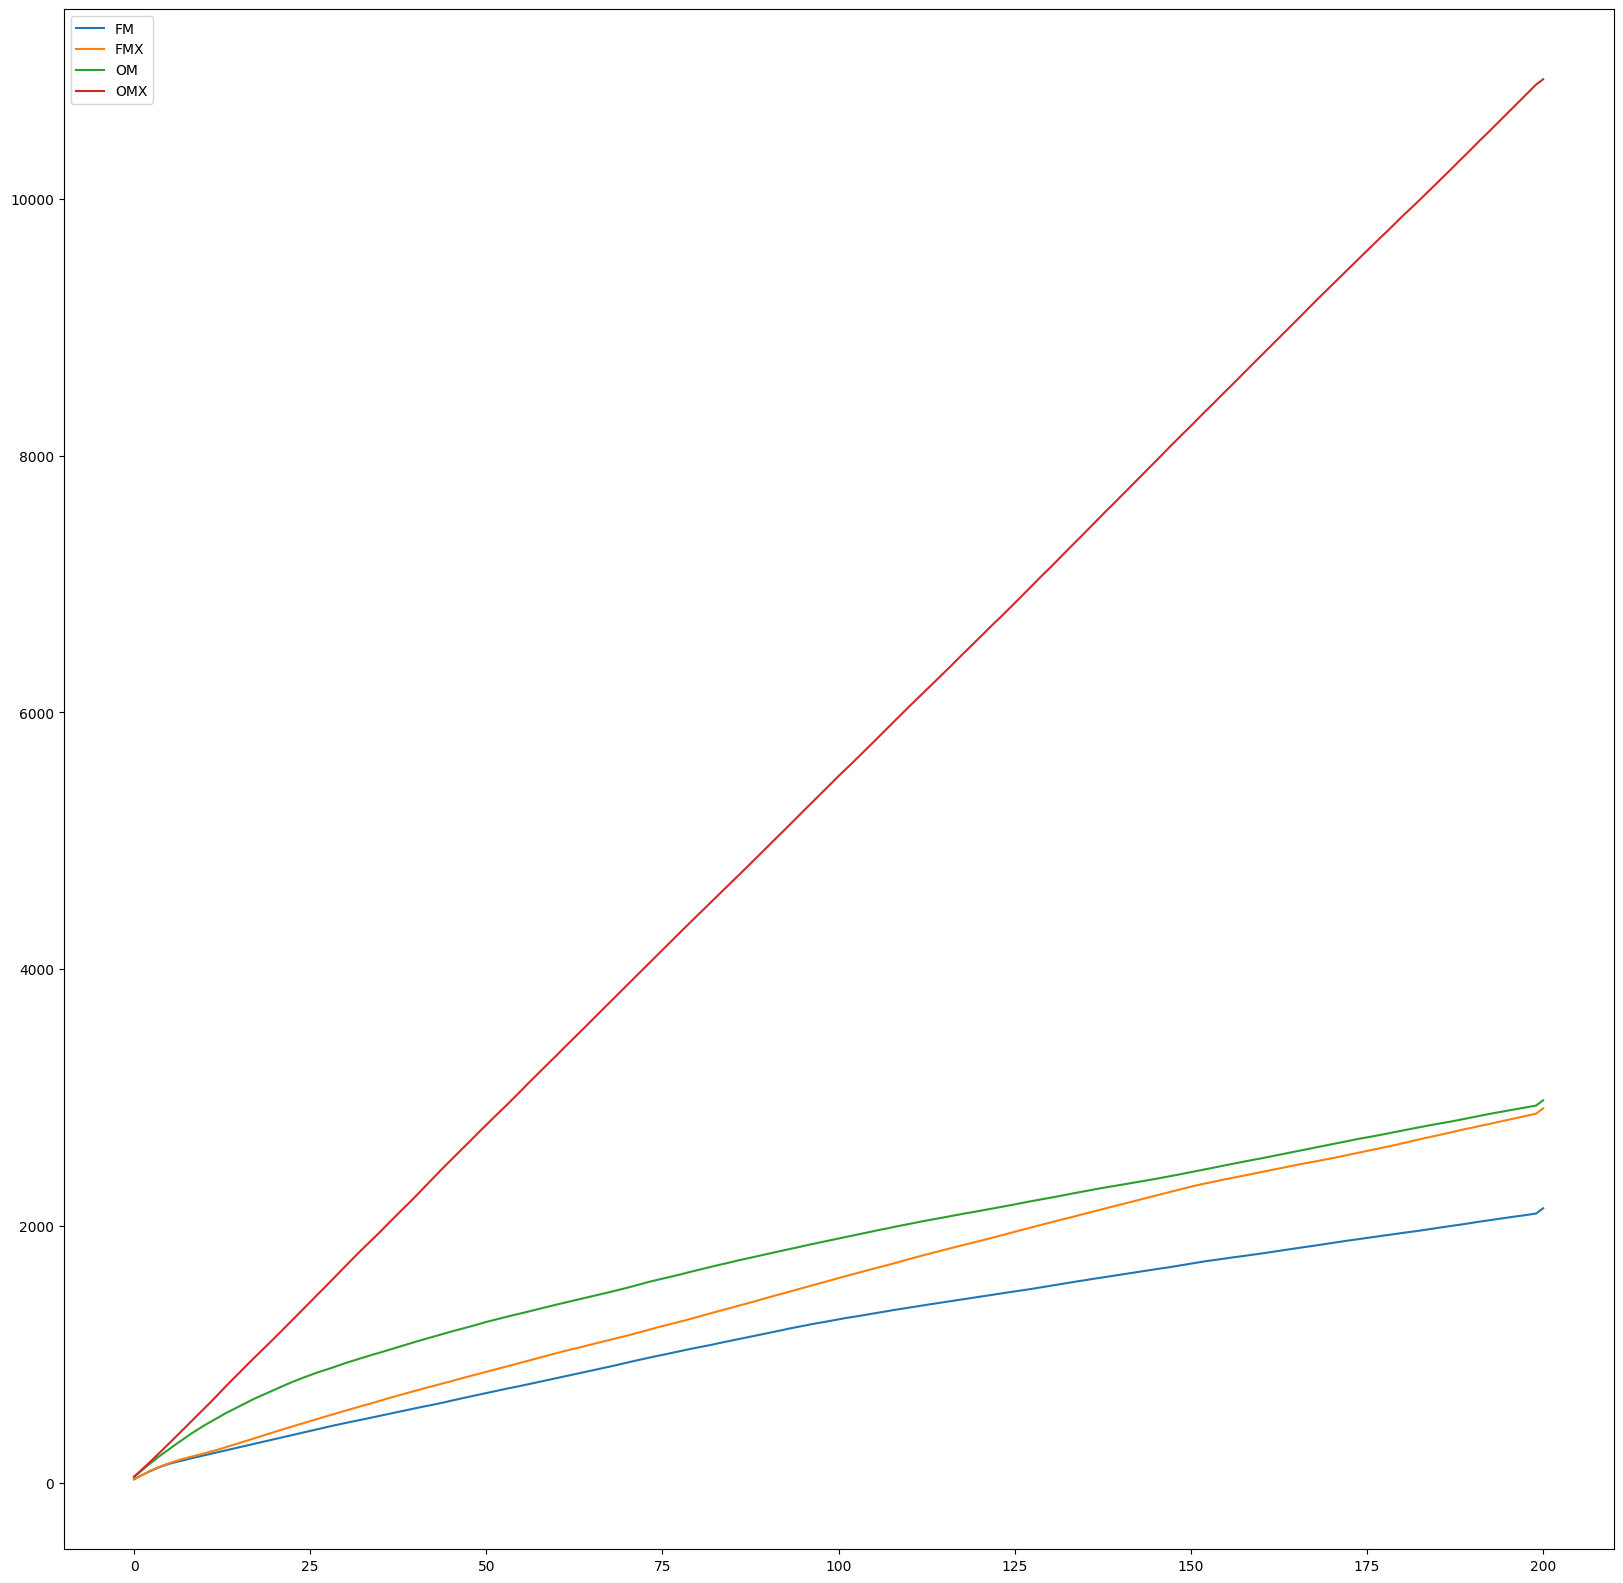

In [6]:
def get_evaluations(df, filter=None):
    total_evaluations = 0.0
    numbers_of_runs = len(df["run"].unique())
    evaluations = np.zeros((numbers_of_runs, 201))
    df = df[filter]
    run_ix = 0
    for run in df["run"].unique():
        df_groupby_run = df[df["run"] == run].groupby("smart_phenotype")

        run_unique_behaviors = len(df_groupby_run.count())
        best_fitness = df[df["run"] == run]["fitness"].min()
        total_evaluations += run_unique_behaviors
        #print(f"Run {run} has {run_unique_behaviors} uniq
        evaluations_per_iteration = df_groupby_run.first().groupby("iteration").count()
        for ix, row in evaluations_per_iteration.iterrows():
            count = row["fitness"] #any column will do
            evaluations[run_ix][ix - 1] += count
        run_ix += 1
    print(f"Average evaluations per run: {total_evaluations / numbers_of_runs} ({numbers_of_runs})")

    return evaluations

print("FM")
fm_evaluations = get_evaluations(df_fm, df_fm['smart_phenotype'].apply(lambda x: "grad" in x))
print("FMX")
fmx_evaluations = get_evaluations(df_fmx, df_fmx['smart_phenotype'].apply(lambda x: "grad" in x))
print("OM")
om_evaluations = get_evaluations(df_om, df_om['smart_phenotype'].apply(lambda x: "grad" in x))
print("OMX")
omx_evaluations = get_evaluations(df_omx, df_omx['smart_phenotype'].apply(lambda x: "grad" in x))
plt.plot(np.arange(201), np.cumsum(np.average(fm_evaluations, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_evaluations, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_evaluations, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_evaluations, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

In [7]:
df_fm['smart_phenotype'].apply(lambda x: "grad" in x)
i = 0
for x in df_fm['smart_phenotype']:
    if 'grad' not in x:
        pass
        #print(i ,x)
    i+=1
df_fm['smart_phenotype'].apply(lambda x: "grad" in x)


0          True
1          True
2          True
3          True
4          True
          ...  
602995     True
602996     True
602997     True
602998     True
602999    False
Name: smart_phenotype, Length: 603000, dtype: bool

FM
Average evaluations per run: 2501.4 (30)
FMX
Average evaluations per run: 3300.133333333333 (30)
OM
Average evaluations per run: 3709.1666666666665 (30)
OMX
Average evaluations per run: 12855.166666666666 (30)


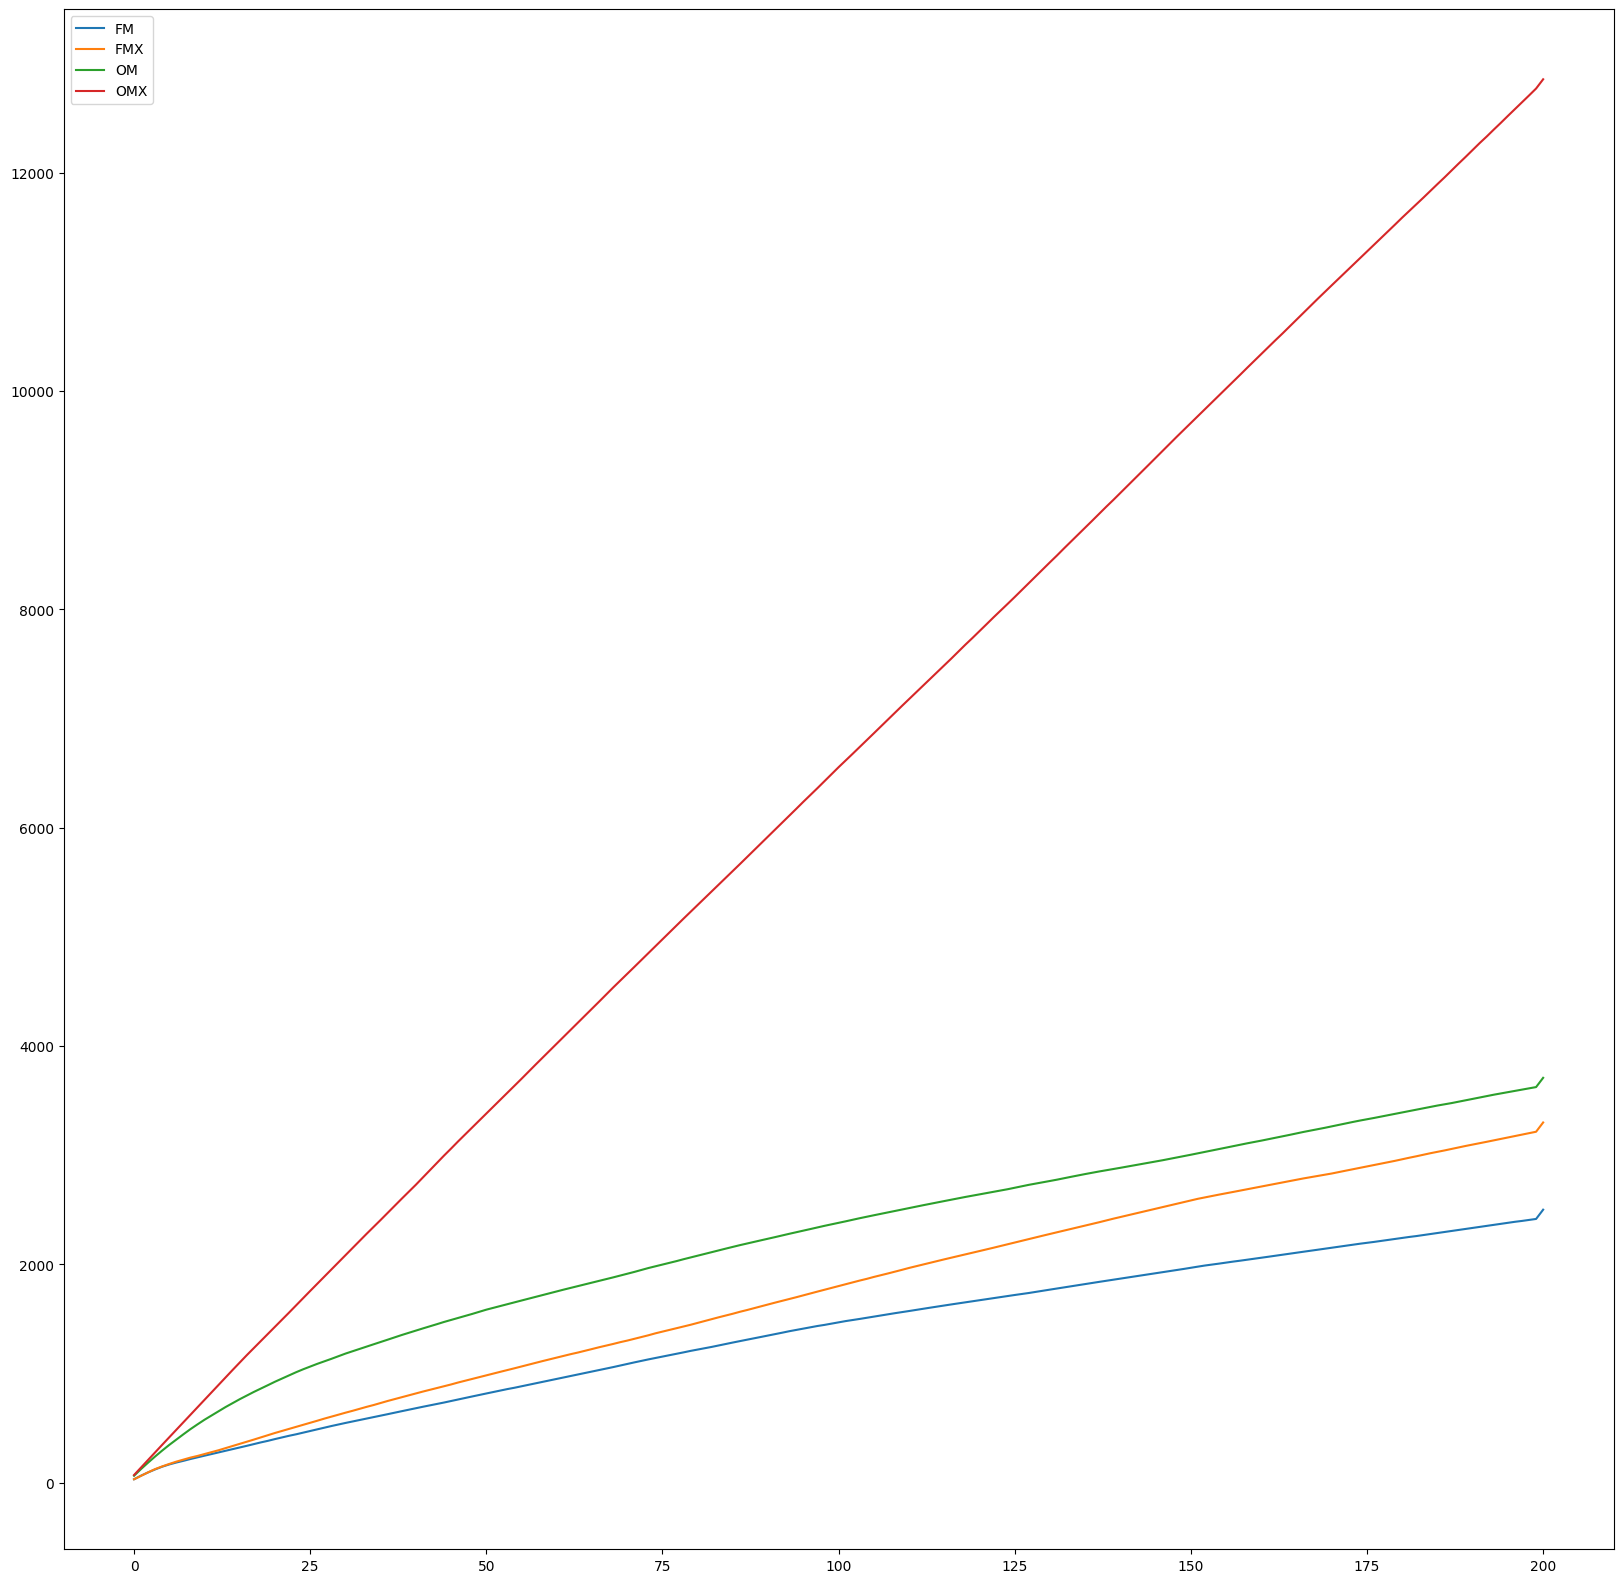

In [8]:
threshold = 1.0

print("FM")
fm_uniques = get_evaluations(df_fm, df_fm['fitness'] < threshold)
print("FMX")
fmx_uniques = get_evaluations(df_fmx, df_fmx['fitness'] < threshold)
print("OM")
om_uniques = get_evaluations(df_om, df_om['fitness'] < threshold)
print("OMX")
omx_uniques = get_evaluations(df_omx, df_omx['fitness'] < threshold)
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

FM
Average evaluations per run: 379.93333333333334 (30)
FMX
Average evaluations per run: 747.5333333333333 (30)
OM
Average evaluations per run: 162.0 (30)
OMX
Average evaluations per run: 133.56666666666666 (30)


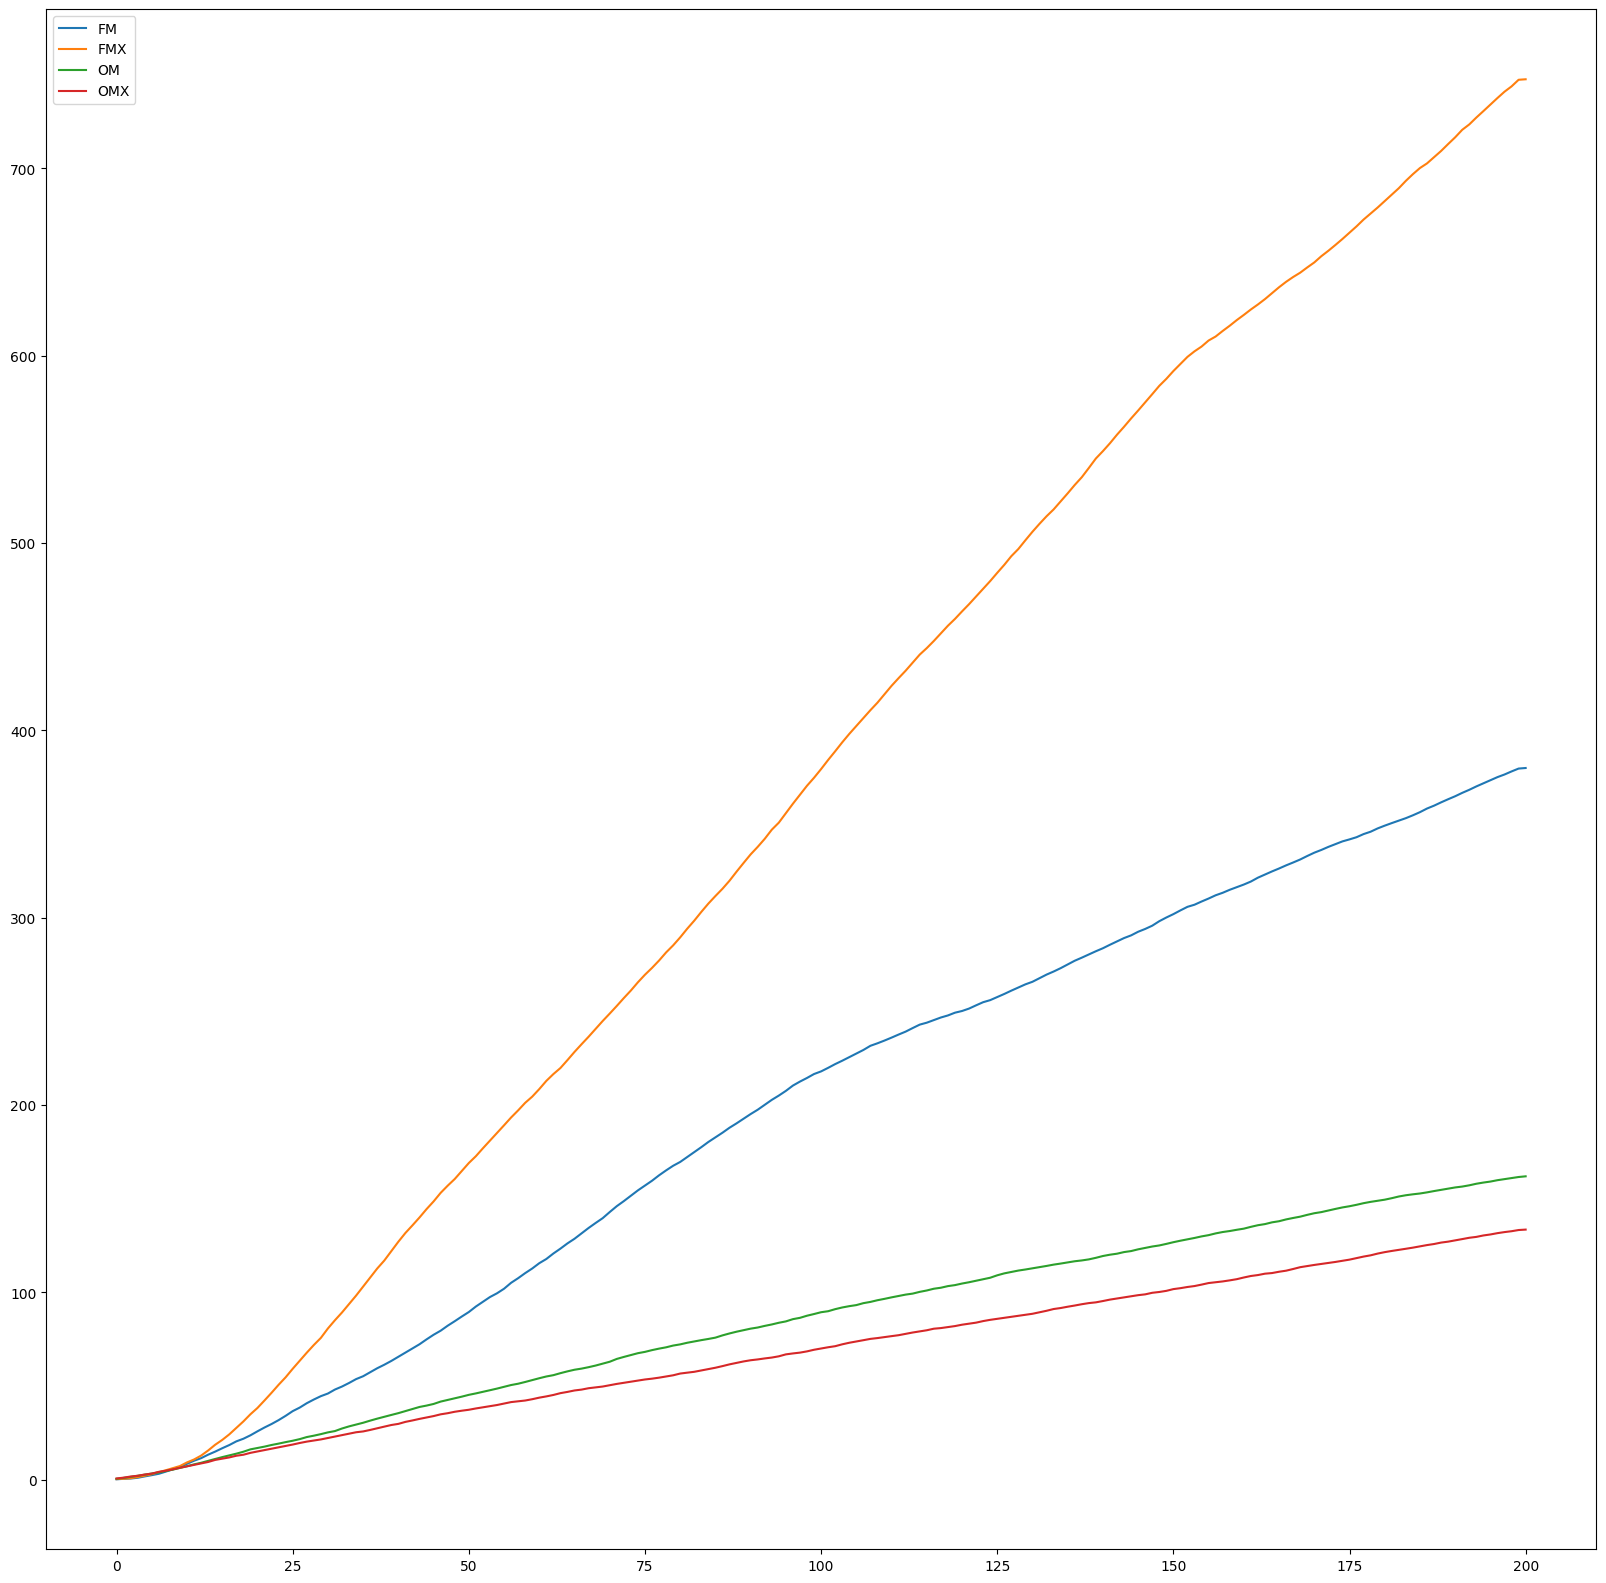

In [9]:
threshold = -0.2

print("FM")
fm_uniques_good = get_evaluations(df_fm, df_fm['fitness'] < threshold)
print("FMX")
fmx_uniques_good = get_evaluations(df_fmx, df_fmx['fitness'] < threshold)
print("OM")
om_uniques_good = get_evaluations(df_om, df_om['fitness'] < threshold)
print("OMX")
omx_uniques_good = get_evaluations(df_omx, df_omx['fitness'] < threshold)
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques_good, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques_good, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques_good, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques_good, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

FM
Average evaluations per run: 279.73333333333335 (30)
FMX
Average evaluations per run: 568.1 (30)
OM
Average evaluations per run: 110.8 (30)
OMX
Average evaluations per run: 63.43333333333333 (30)


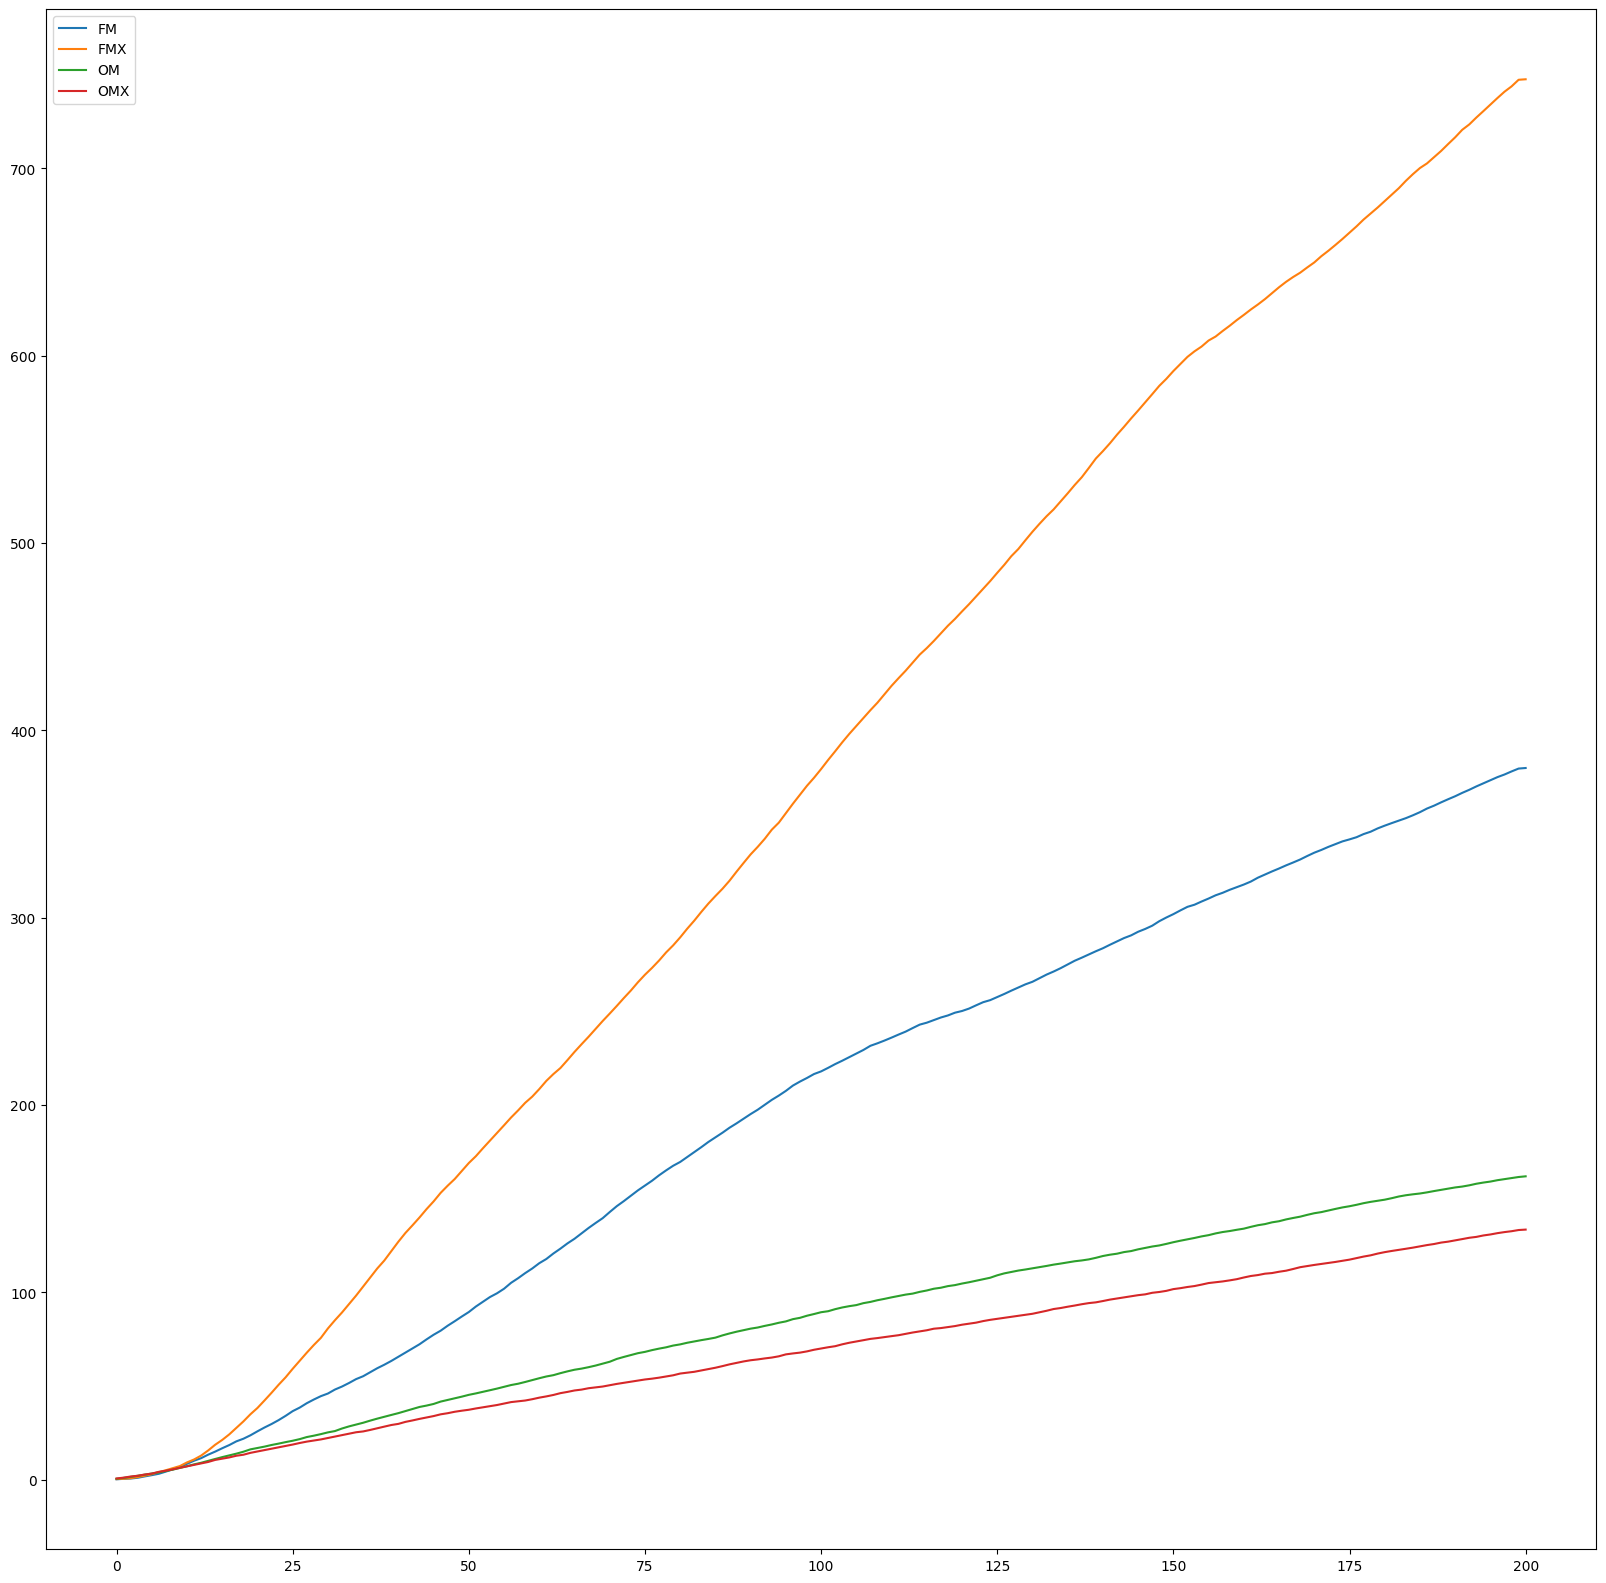

In [10]:
threshold = -0.6

print("FM")
fm_uniques_best = get_evaluations(df_fm, df_fm['fitness'] < threshold)
print("FMX")
fmx_uniques_best = get_evaluations(df_fmx, df_fmx['fitness'] < threshold)
print("OM")
om_uniques_best = get_evaluations(df_om, df_om['fitness'] < threshold)
print("OMX")
omx_uniques_best = get_evaluations(df_omx, df_omx['fitness'] < threshold)
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques_good, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques_good, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques_good, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques_good, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

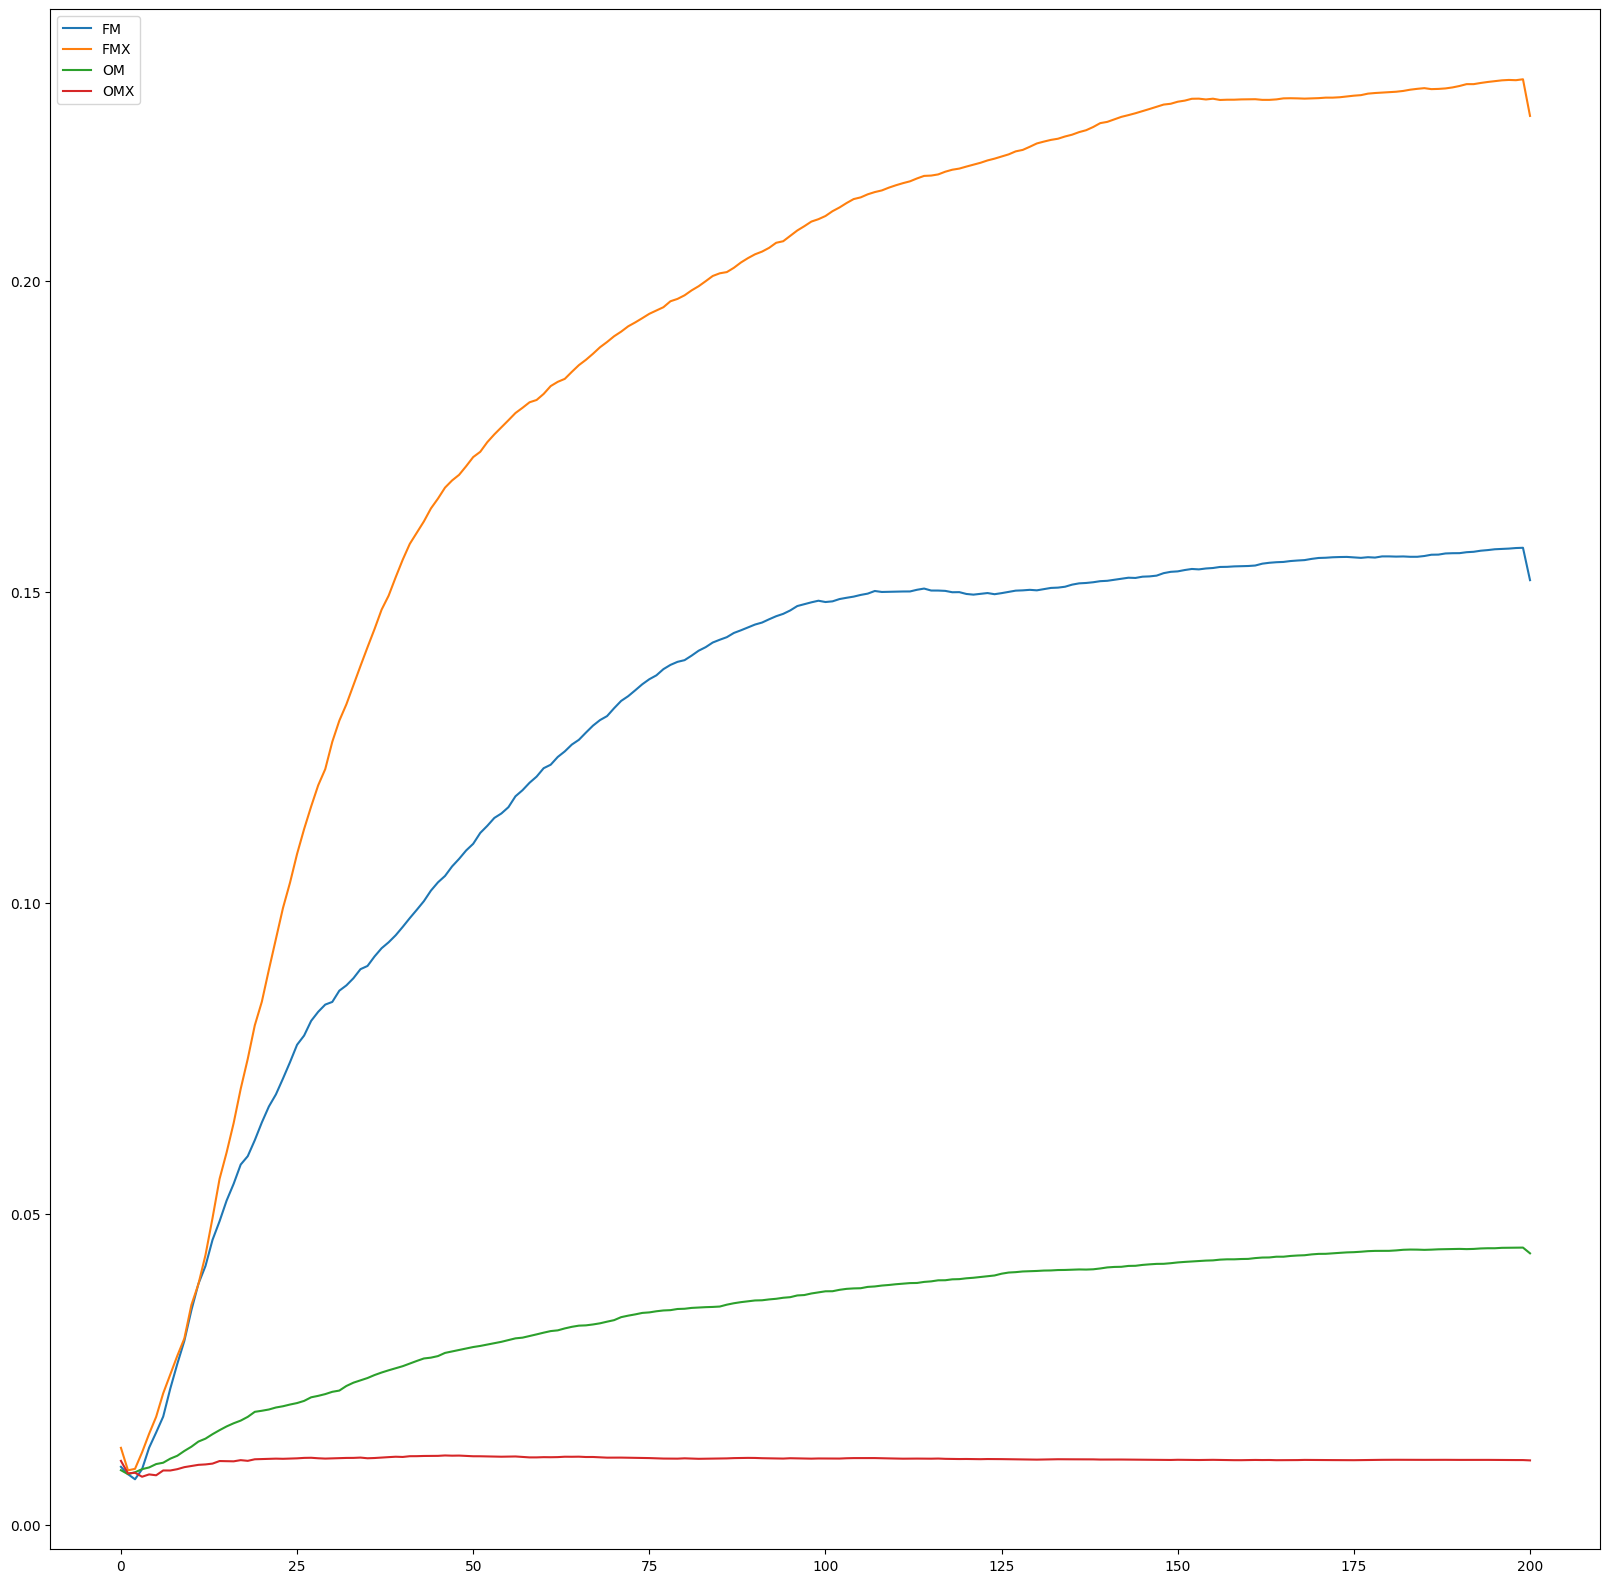

In [13]:
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques_good, axis=0), axis=0) /  np.cumsum(np.average(fm_uniques, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques_good, axis=0), axis=0) /  np.cumsum(np.average(fmx_uniques, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques_good, axis=0), axis=0) /  np.cumsum(np.average(om_uniques, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques_good, axis=0), axis=0) /  np.cumsum(np.average(omx_uniques, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

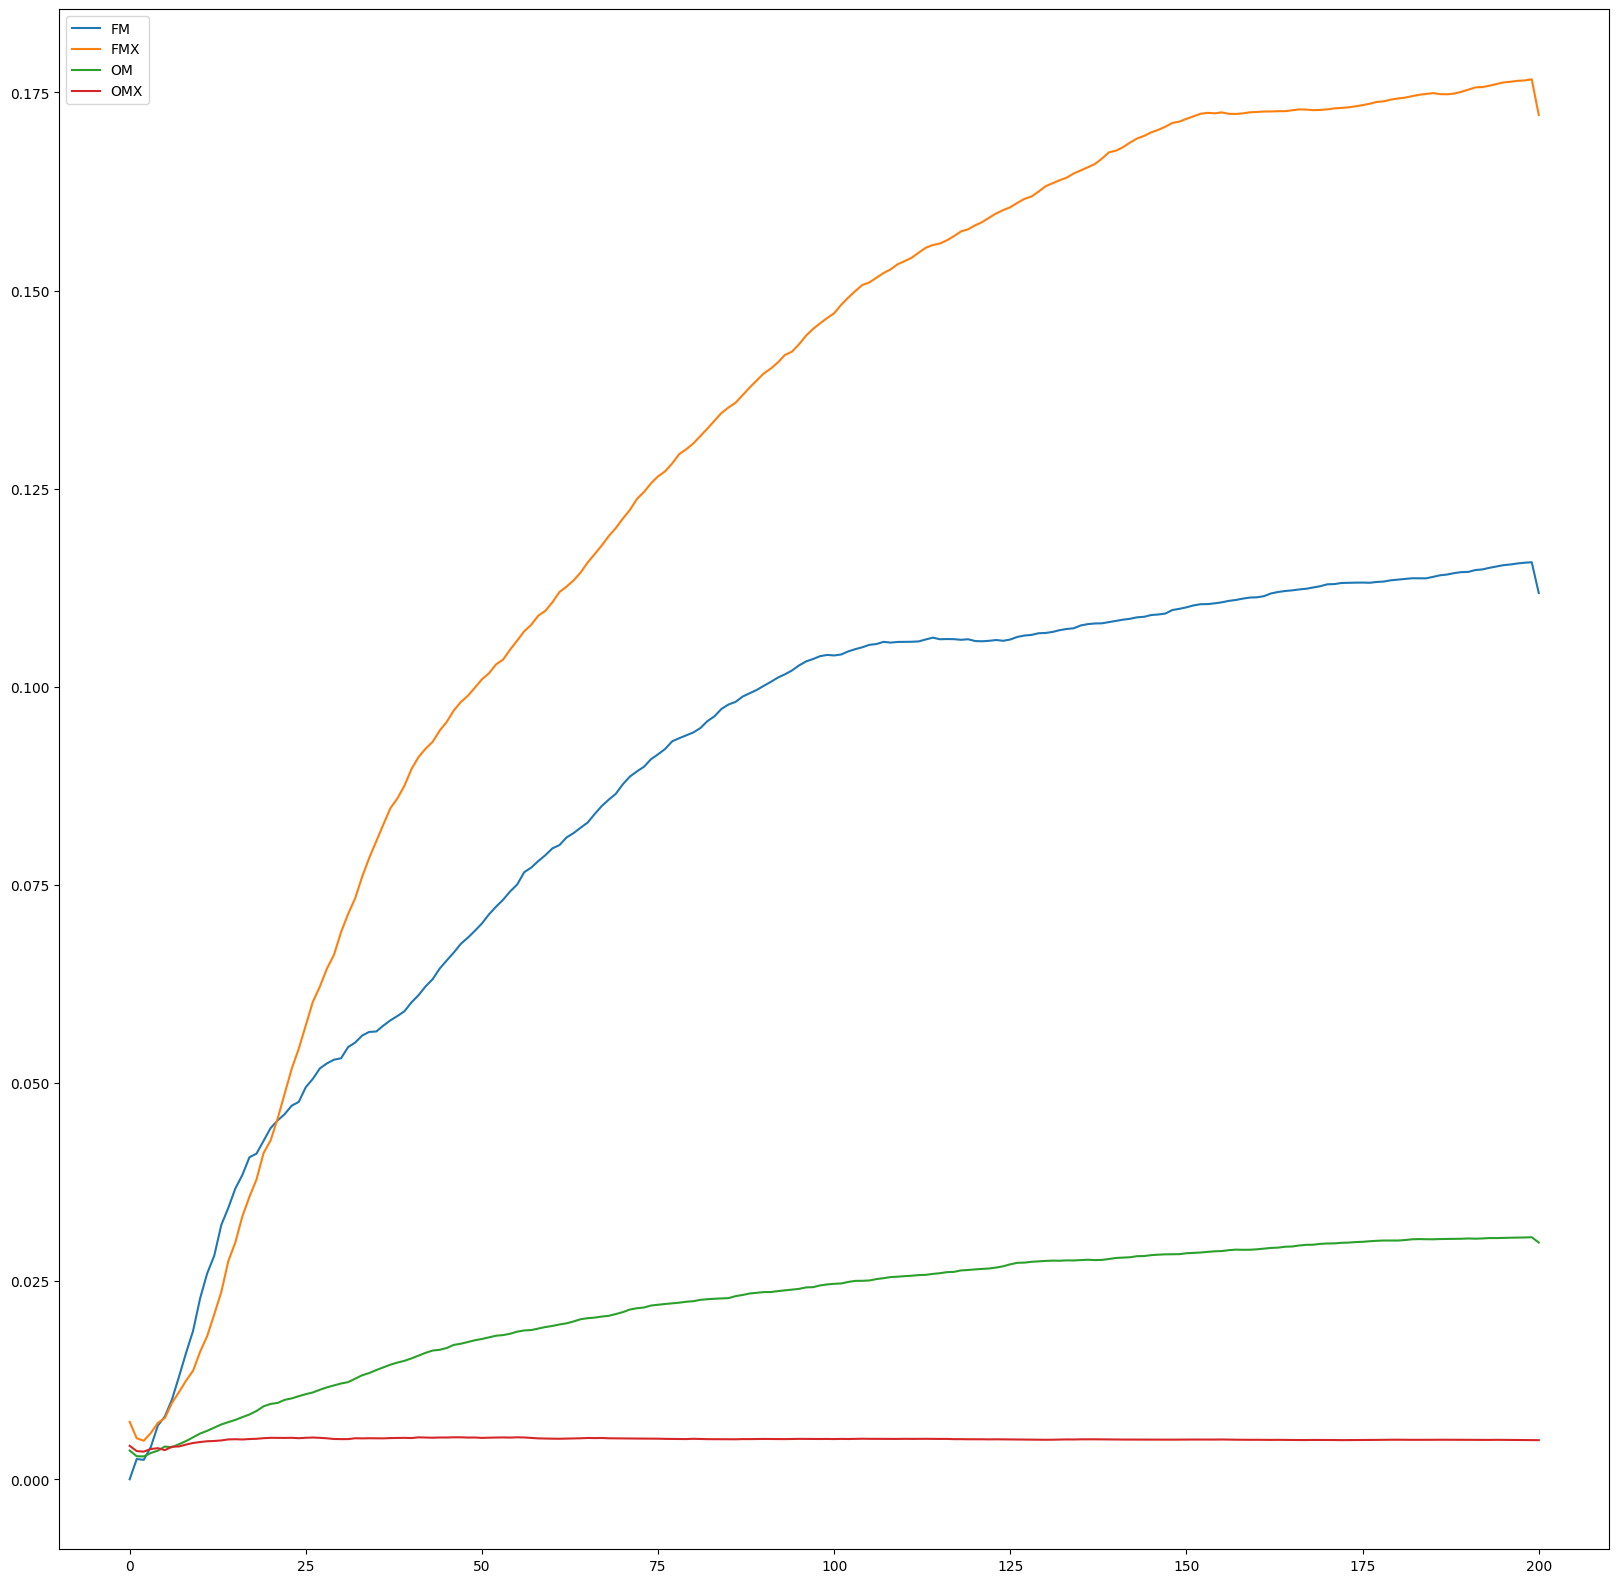

In [14]:
plt.plot(np.arange(201), np.cumsum(np.average(fm_uniques_best, axis=0), axis=0) /  np.cumsum(np.average(fm_uniques, axis=0), axis=0), label="FM")
plt.plot(np.arange(201), np.cumsum(np.average(fmx_uniques_best, axis=0), axis=0) /  np.cumsum(np.average(fmx_uniques, axis=0), axis=0), label="FMX")
plt.plot(np.arange(201), np.cumsum(np.average(om_uniques_best, axis=0), axis=0) /  np.cumsum(np.average(om_uniques, axis=0), axis=0), label="OM")
plt.plot(np.arange(201), np.cumsum(np.average(omx_uniques_best, axis=0), axis=0) /  np.cumsum(np.average(omx_uniques, axis=0), axis=0), label="OMX")
plt.legend()
plt.show()

In [31]:
from smart_phenotype import readable_phenotype
print(readable_phenotype(df_fm.sort_values(by=['fitness'])['phenotype'].iloc[0]))
print(df_fm.sort_values(by=['fitness'])['phenotype'].iloc[0])
print("---")
print(df_fmx.sort_values(by=['fitness'])['phenotype'].iloc[0])
print("---")
print(df_om.sort_values(by=['fitness'])['phenotype'].iloc[0])
print("---")
print(df_omx.sort_values(by=['fitness'])['phenotype'].iloc[0])


divide_no_nan(grad, constant(1.72012560e-03))
constant(8.59898661e-03)
multiply(add(add(sigma, grad), grad), constant(1.56514861e-02))
negative(sigma)

alpha_func, beta_func, sigma_func, grad_func = lambda shape,  alpha, grad: tf.math.divide_no_nan(grad, tf.constant(1.72012560e-03, shape=shape, dtype=tf.float32)), lambda shape,  alpha, beta, grad: tf.constant(8.59898661e-03, shape=shape, dtype=tf.float32), lambda shape,  alpha, beta, sigma, grad: tf.math.multiply(tf.math.add(tf.math.add(sigma, grad), grad), tf.constant(1.56514861e-02, shape=shape, dtype=tf.float32)), lambda shape,  alpha, beta, sigma, grad: tf.math.negative(sigma)
---
alpha_func, beta_func, sigma_func, grad_func = lambda shape,  alpha, grad: tf.math.pow(grad, tf.constant(9.99372875e-01, shape=shape, dtype=tf.float32)), lambda shape,  alpha, beta, grad: tf.math.add(grad, grad), lambda shape,  alpha, beta, sigma, grad: tf.math.subtract(tf.math.multiply(tf.math.add(sigma, grad), tf.constant(8.92170603e-02, shape=shape, dt

In [ ]:
df = df_fm
print(np.average(df, axis=0).head(5))
print(df.apply(np.average, axis=1).head(5))